# Stimare Q function ottimale
## 1. Quanto tempo ci mette per convergere a Q*, al variare di tau
## 2. Distanza tra Q* e Q_t 
## 3. distanza tra Q_0 e Q_0 appresa tramite i valori di tau
## 4. cercare di integrare i bound trovati
## 5. Test della policy appresa con tau sull'mdp originale
## 6. Performance durante l'apprendimento per verificare la convergenza
## 7. Approfondire cosa succede per 0 < tau < 0.1 

In [1]:
import numpy as np
from TMDP import TMDP
from river_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
import math
from utils import *

In [2]:
# Test with tau=0.9
nS = 8
nA = 2
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.9
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma)

In [3]:
results = []

r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)
print(delta_q)
results.append({"type":"Bellman", "Q": Q_star, "tau":"/", "J":J_star, "policy":get_policy(Q_star), "delta_q":delta_q})
print(results)

0.0
[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': 365.78861003317843, 'policy': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]]), 'delta_q': 0.0}]


In [4]:

taus = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
intermediate_results = {}
curr_results = []
Q = np.zeros((tmdp.nS, tmdp.nA))
# Curriculul for decreasing values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    M = 20000
    s = tmdp.reset()
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q, inner_J = Q_learning(tmdp, s, a, Q, M, status_step=1000)
    curr_results.append(inner_J)
curr_results = np.ravel(curr_results)
intermediate_results['Curriculum'] = curr_results
delta_q = np.linalg.norm(Q_star - Q, np.inf)
J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
results.append({"type":"curriculum", "Q": Q, "tau":"1 -> 0", "J":J, "policy":get_policy(Q), "delta_q":delta_q})



In [5]:
print(curr_results)
print(get_policy)

[  0.    173.373 165.208  86.843 246.482 189.092   0.     51.37   75.35
 365.789  67.154 165.208 191.549  51.37  173.373 246.482 246.482 246.482
 273.894   0.      0.    246.482  27.992  76.849  51.37   14.415  71.665
  51.37   51.37   51.37    0.    186.363 246.482 197.219  51.37  165.208
 165.208 165.208  71.468  13.603  51.37   51.37   68.823  51.37   74.395
 175.741 265.517  71.665  51.37   19.071   0.     74.119 302.394 179.584
 179.584 189.092 183.33  165.208   0.    165.208 256.406  51.37   71.665
 362.55    0.     62.361 273.894 165.208 307.026 165.208 273.894 265.517
  51.37   51.37   51.37   76.849 246.482 174.99    0.     64.972  13.992
 259.881   0.     17.288  51.37  246.482  66.449 179.073 165.208 165.208
 191.549 316.061 180.716 165.208 165.208  14.428 165.208  64.972   0.
 173.784  66.481   8.698  51.37    0.    191.549 246.482 197.219 302.394
 191.549 165.208  75.35  197.219 316.061 316.061  71.468   8.074 246.482
  51.37   64.972  13.416 254.902  70.112  19.071 165.20

In [6]:
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    M = 200000
    
    s = tmdp.reset()
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q, inner_J = Q_learning(tmdp, s, a, Q, M, status_step=1000)
    intermediate_results['tau_'+str(tau)] = inner_J
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    results.append({"type":"scratch", "Q": Q, "tau":"{:.1f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

In [7]:
# Read previous results from file
try:
    res = read_results(tmdp.nS, tmdp.nA, "river_swim")
except:
    res = []
    
# Add current results to old ones
for r in results:
    res.append(r)





In [8]:
# Update overall results
write_results(tmdp.nS, tmdp.nA, "river_swim", res, 'w')
agg_res = aggregate_results(res, len(results))

In [9]:
print(agg_res)

[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': [365.78861003317843, 365.78861003317843, 365.78861003317843], 'policy': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]]), 'delta_q': [0.0, 0.0, 0.0], 'avg_J': 365.78861003317843, 'avg_delta_q': 0.0}, {'type': 'curriculum', 'Q': array([[  50.   ,   43.532],
       [  45.   ,   42.021],
       [  48.216,   49.545],
       [  55.34 ,   55.972],
       [  74.183,   74.387],
       [ 114.257,  150.246],
       [ 150.497,  156.052],
       [ 340.074, 1303.313]]), 'tau': '1 -> 0', 'J': [355.03300635211065, 340.6844168677573, 70.11234332645927], 'policy': array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 

In [10]:
pi = get_policy(Q_star, False)
print(Q_star)
print(pi)

[[ 68.054  70.06 ]
 [ 63.054  96.009]
 [ 86.408 140.217]
 [126.195 206.885]
 [186.197 305.732]
 [275.159 451.916]
 [406.724 668.02 ]
 [601.218 987.469]]
[[1.186e-001 8.814e-001]
 [4.876e-015 1.000e+000]
 [4.275e-024 1.000e+000]
 [9.052e-036 1.000e+000]
 [1.220e-052 1.000e+000]
 [1.720e-077 1.000e+000]
 [3.317e-114 1.000e+000]
 [1.791e-168 1.000e+000]]


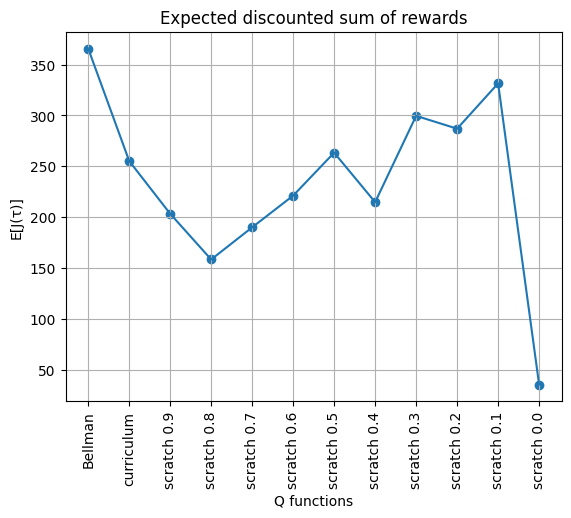

In [11]:
x = []
y = []
for res in agg_res:
    x.append(res['avg_J'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)




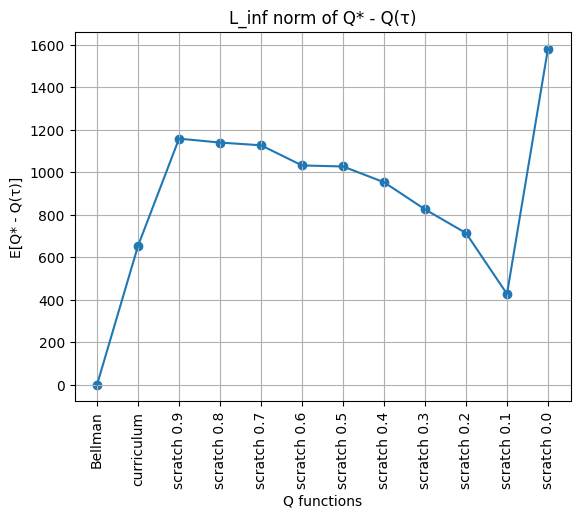

In [12]:
x = []
y = []
for res in agg_res:
    x.append(res['avg_delta_q'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[Q* - Q(τ)]")
plt.title("L_inf norm of Q* - Q(τ)")
plt.grid(visible=True)

In [13]:
print(len(agg_res[0]['J']))

3


In [14]:
V_star = get_value_function(Q_star)
print(V_star)

A = get_policy_advantage_function(Q_star, False)
print(A)

[ 70.06   96.009 140.217 206.885 305.732 451.916 668.02  987.469]
[[-1.768e+00  2.379e-01]
 [-3.295e+01  1.563e-13]
 [-5.381e+01  0.000e+00]
 [-8.069e+01  0.000e+00]
 [-1.195e+02  0.000e+00]
 [-1.768e+02  0.000e+00]
 [-2.613e+02  0.000e+00]
 [-3.863e+02  0.000e+00]]


In [15]:
A = get_model_advantage_function(tmdp.P_mat, tmdp.reward, tmdp.gamma, Q_star, True)
print(tmdp.P_mat)
pi_prime = np.array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])
A_pi_pi_prime = get_relative_policy_advantage_function(Q_star, pi_prime)
print(A_pi_pi_prime)

[[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.7 0.3 0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.6 0.3 0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.6 0.3 0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.6 0.3 0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.6 0.3 0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.6 0.3 0. ]
 [0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.6 0.3]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.7 0.3]]
[ -2.006 -32.954 -53.809   0.      0.      0.      0.      0.   ]


In [16]:
print(len(intermediate_results.keys()))


11


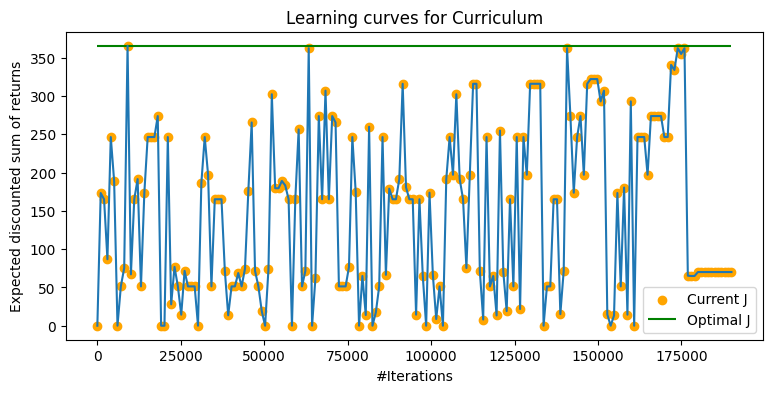

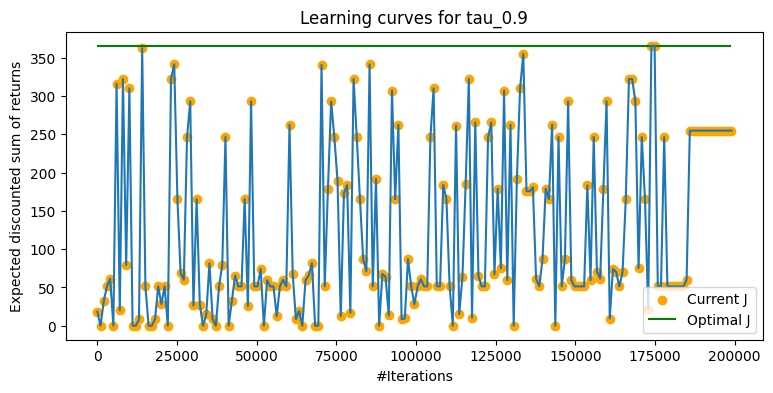

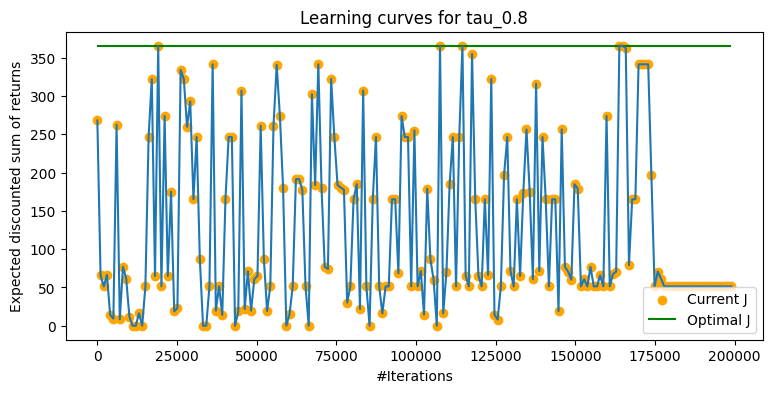

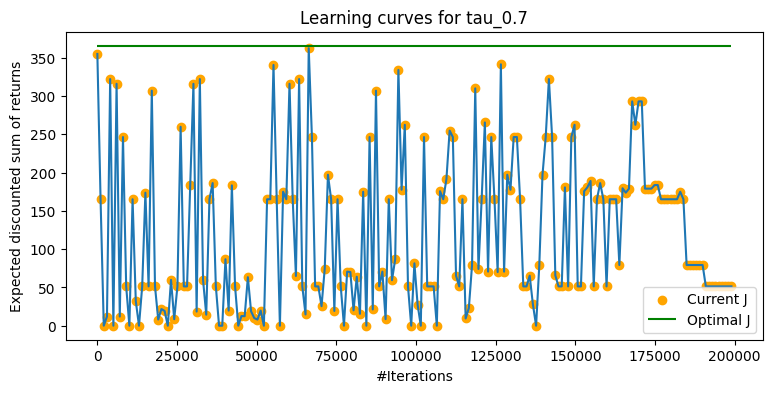

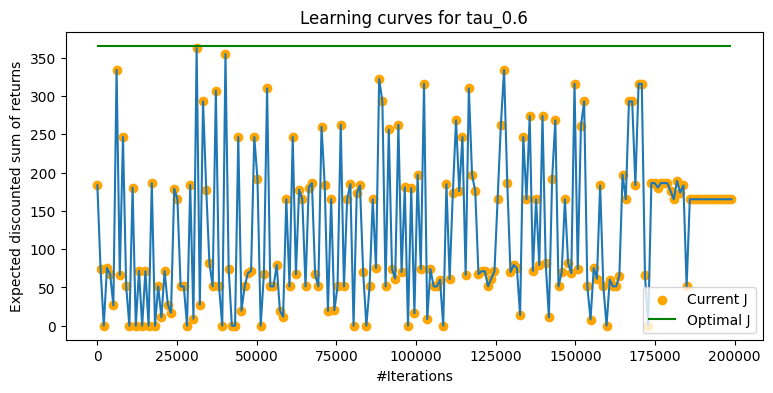

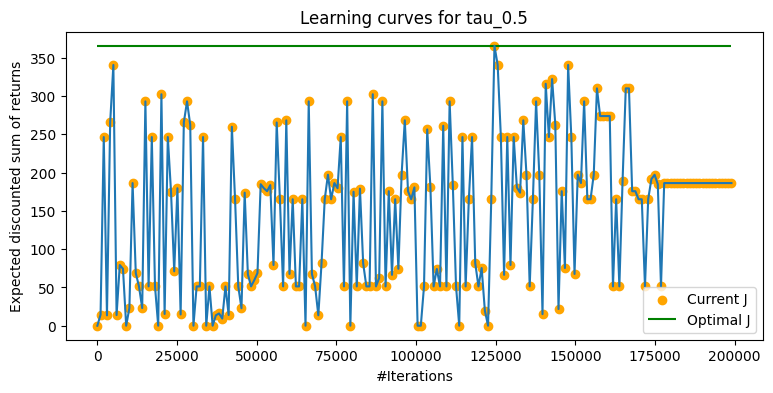

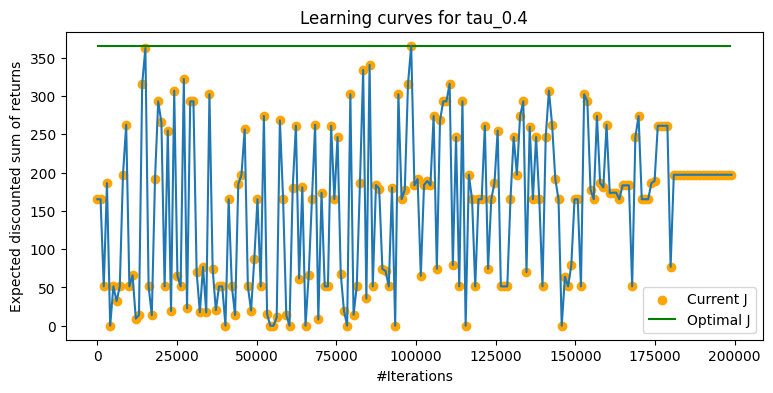

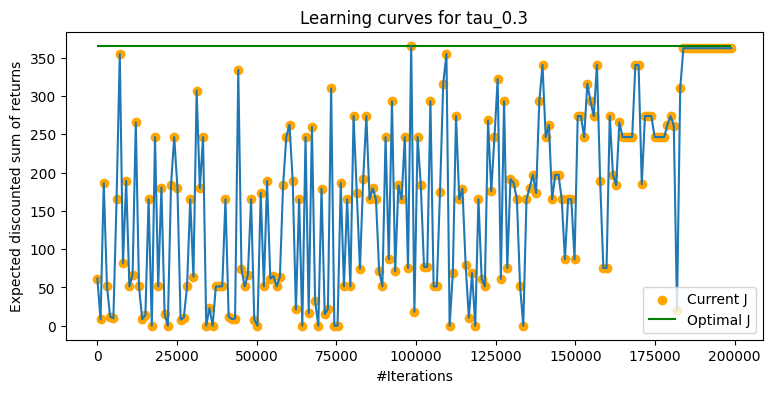

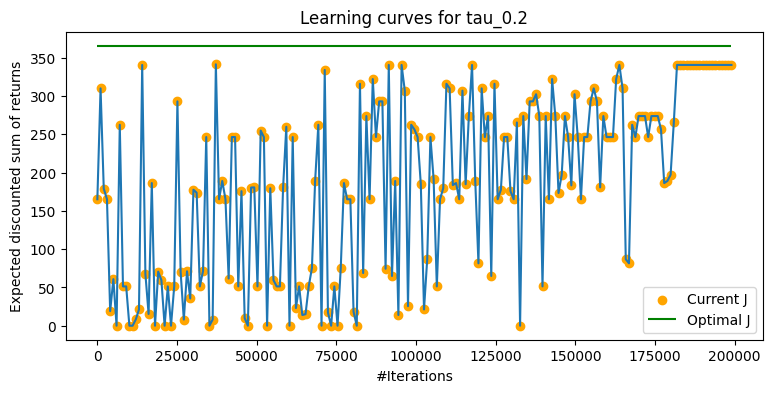

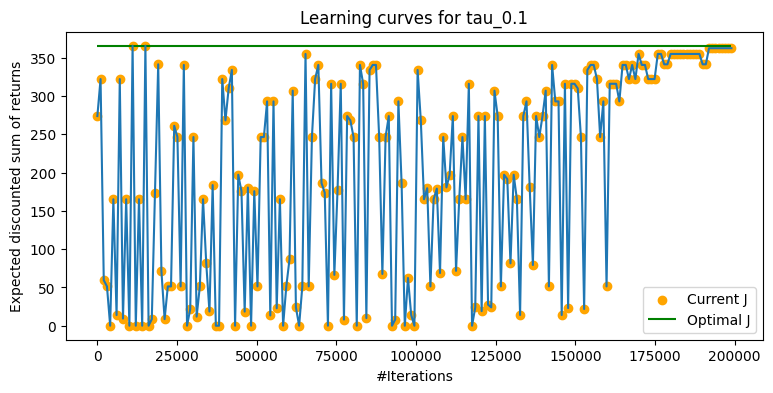

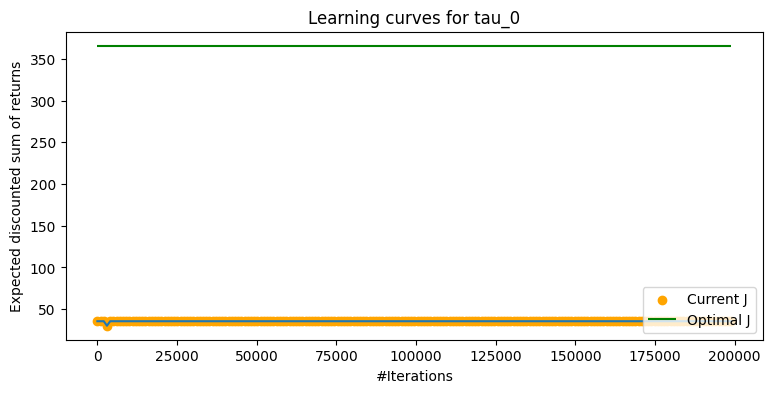

In [17]:
for i, key in enumerate(intermediate_results.keys()):
    status_step = 1000
    xmax = len(intermediate_results[key])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]))
    y = intermediate_results[key]
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    plt.plot(x, y)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))